In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle360(x,y):
    return abs(math.degrees(np.arctan2(y,x))) if y < 0 else abs(math.degrees(np.arctan2(y,x))-360)

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'E:/Aaron/Combined_Confocal_PCA_nospeedoutliers/'
savedir = datadir + 'Galvanotaxis/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

#limit data to the 30C Galv experiments
TotalFrame = FullFrame[(FullFrame.Experiment == 'Galvanotaxis') & (FullFrame.Temperature == '30C')]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


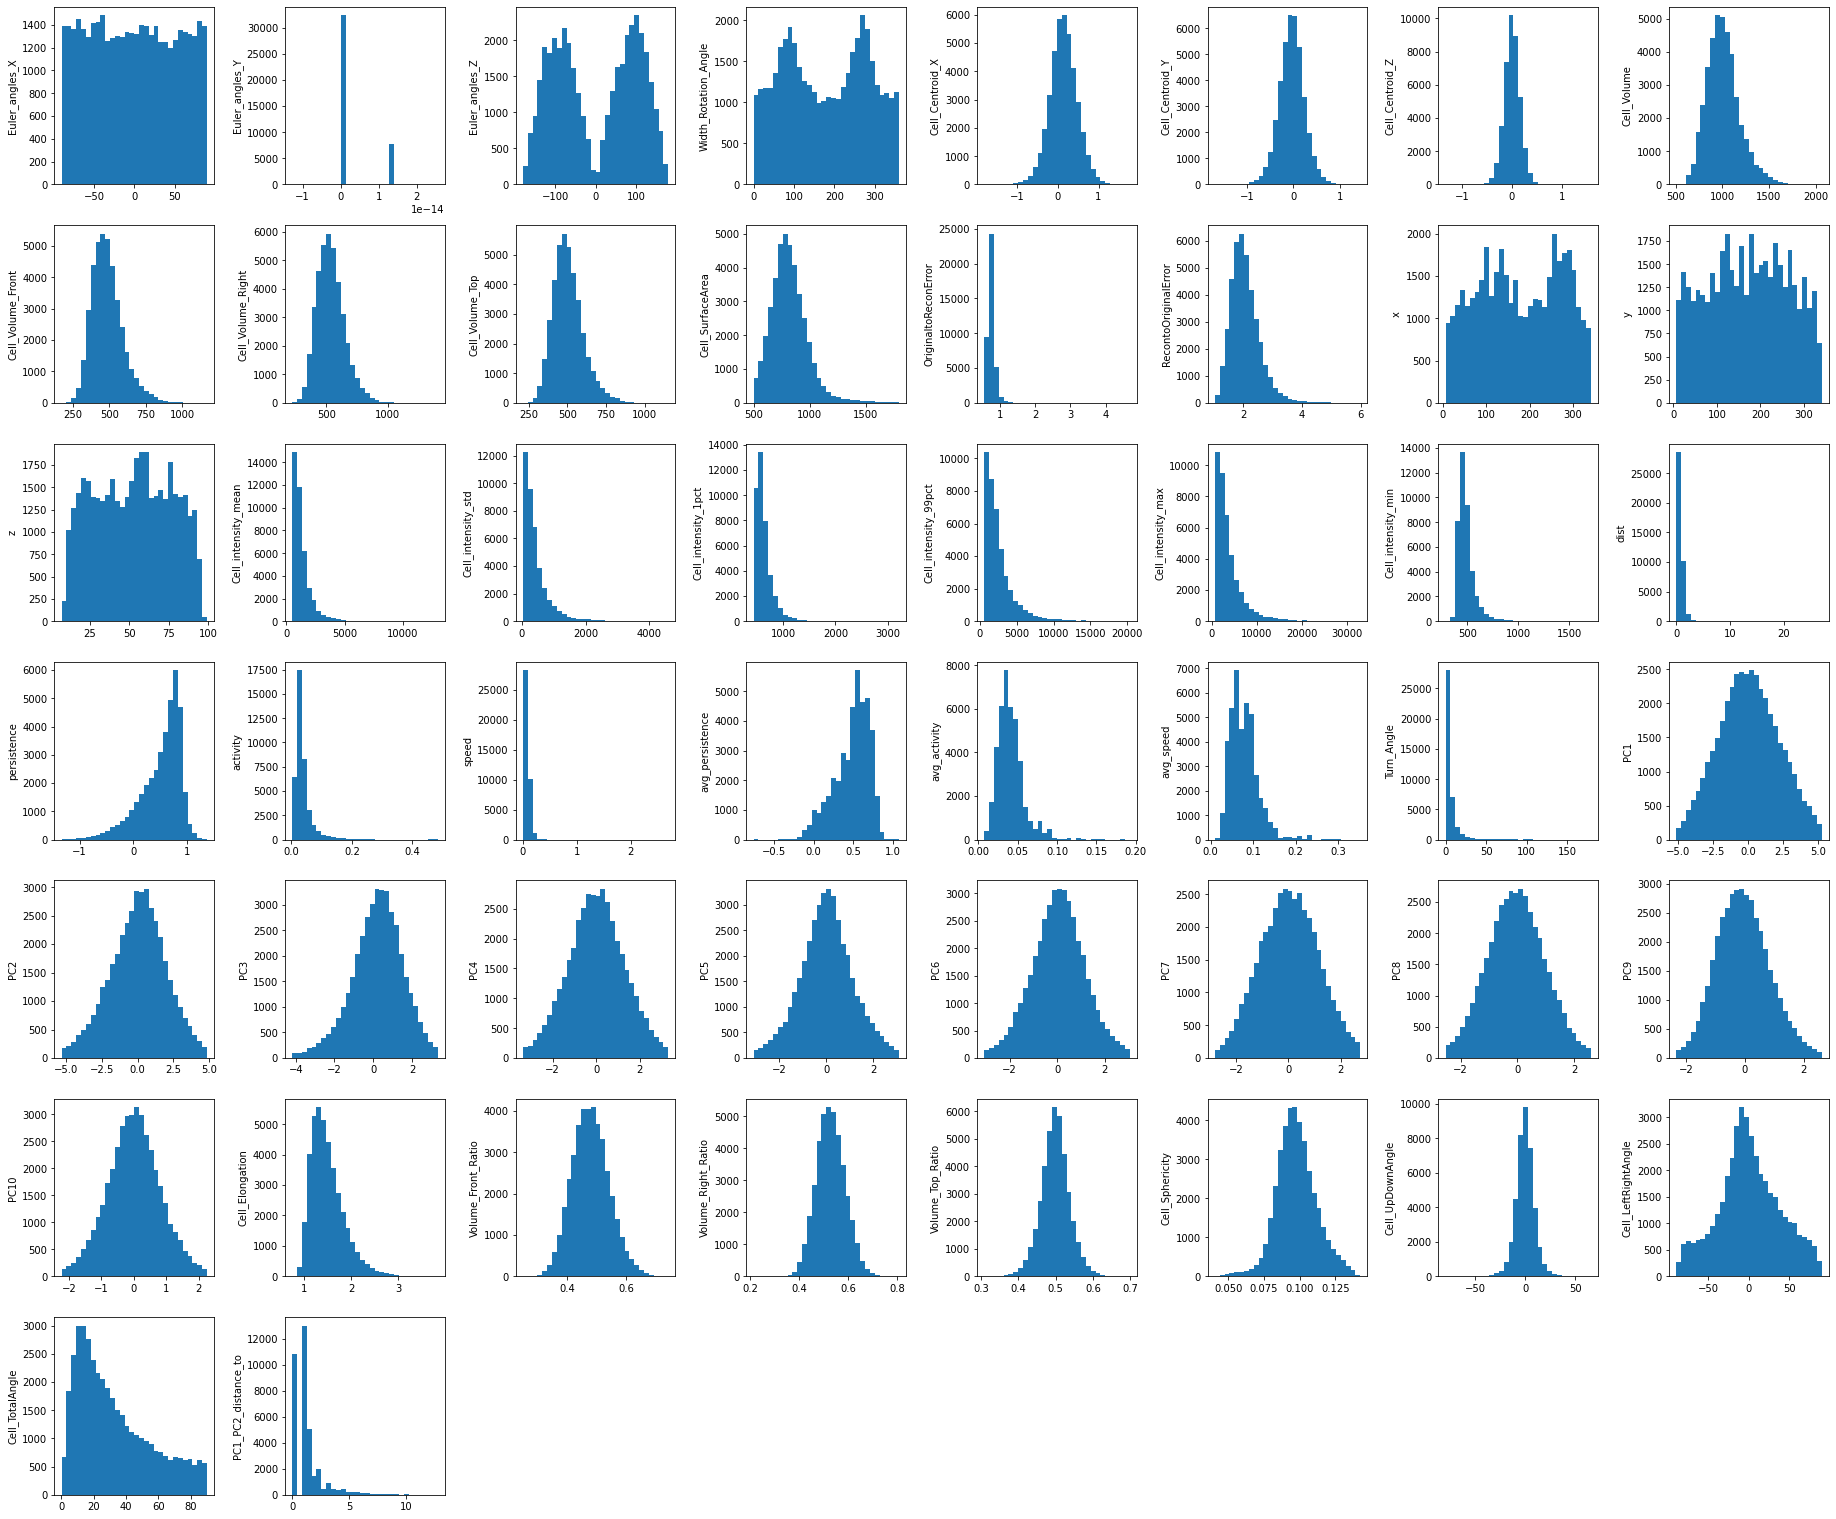

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame','Treatment'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

In [38]:
TotalFrame.Turn_Angle.dropna().sort_values(ascending=False).head(200)

55578    179.369632
29967    178.818021
29953    178.317207
43995    177.448597
38274    176.540657
            ...    
29965     84.122093
58635     84.107094
38362     84.095905
42329     83.551875
38357     83.318013
Name: Turn_Angle, Length: 200, dtype: float64

In [4]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        f_val, p_val = ss.f_oneway(*samples)
        print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
        if p_val < 0.05:
            siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Cell_Volume, F value: 53.01542617145497, p value: 1.0986898239074188e-23
Name: Cell_Volume_Front, F value: 26.666766905051606, p value: 2.7245384181243583e-12
Name: Cell_Volume_Right, F value: 49.53063460848471, p value: 3.515827224714161e-22
Name: Cell_Volume_Top, F value: 42.089891858775964, p value: 5.777086150814344e-19
Name: Cell_SurfaceArea, F value: 11.270295093619815, p value: 1.283298096014738e-05
Name: dist, F value: 1.1231592594026598, p value: 0.3252726105560657
Name: persistence, F value: 4.920407783052046, p value: 0.007305932388315611
Name: speed, F value: 2.3690362031881307, p value: 0.09359945300116602
Name: avg_persistence, F value: 3.231222744402161, p value: 0.039531271956160983
Name: avg_speed, F value: 12.138347181151005, p value: 5.392743378676181e-06
Name: Instant_Signal_Velocity, F value: 57.307951213858885, p value: 1.5445253084499344e-25
Name: Signal_Velocity, F value: 183.6682808652501, p value: 1.0493677864513319e-79
Name: Total_Distance_Travelled, F 

Name Euclidean_Distance_Travelled            Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis  -3.9865   0.0  -5.7531  -2.2198   True
    Galvanotaxis           Random -12.3324  -0.0 -13.2651 -11.3997   True
Pre-Galvanotaxis           Random  -8.3459  -0.0  -10.079  -6.6128   True
-------------------------------------------------------------------------
Name Instant_Signal_Velocity           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis  -0.0114    0.0 -0.0161 -0.0066   True
    Galvanotaxis           Random  -0.0111   -0.0 -0.0137 -0.0086   True
Pre-Galvanotaxis           Random   0.0002 0.9936 -0.0

Name Volume_Top_Ratio           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis   0.0047 0.0004  0.0018  0.0075   True
    Galvanotaxis           Random   0.0004 0.8299 -0.0011  0.0019  False
Pre-Galvanotaxis           Random  -0.0043 0.0009 -0.0071 -0.0015   True
------------------------------------------------------------------------
Name avg_persistence           Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis   0.0073 0.3183 -0.0046 0.0193  False
    Galvanotaxis           Random   0.0065 0.0402  0.0002 0.0128   True
Pre-Galvanotaxis           Random  -0.0008 0.9843 -0.0125 0.0108  False
--------------

In [81]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Treatment'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

,Migration_Mode,Cells,Images
0,Random,129,8397
1,Pre-Galvanotaxis,78,1242
2,Galvanotaxis,134,7837


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


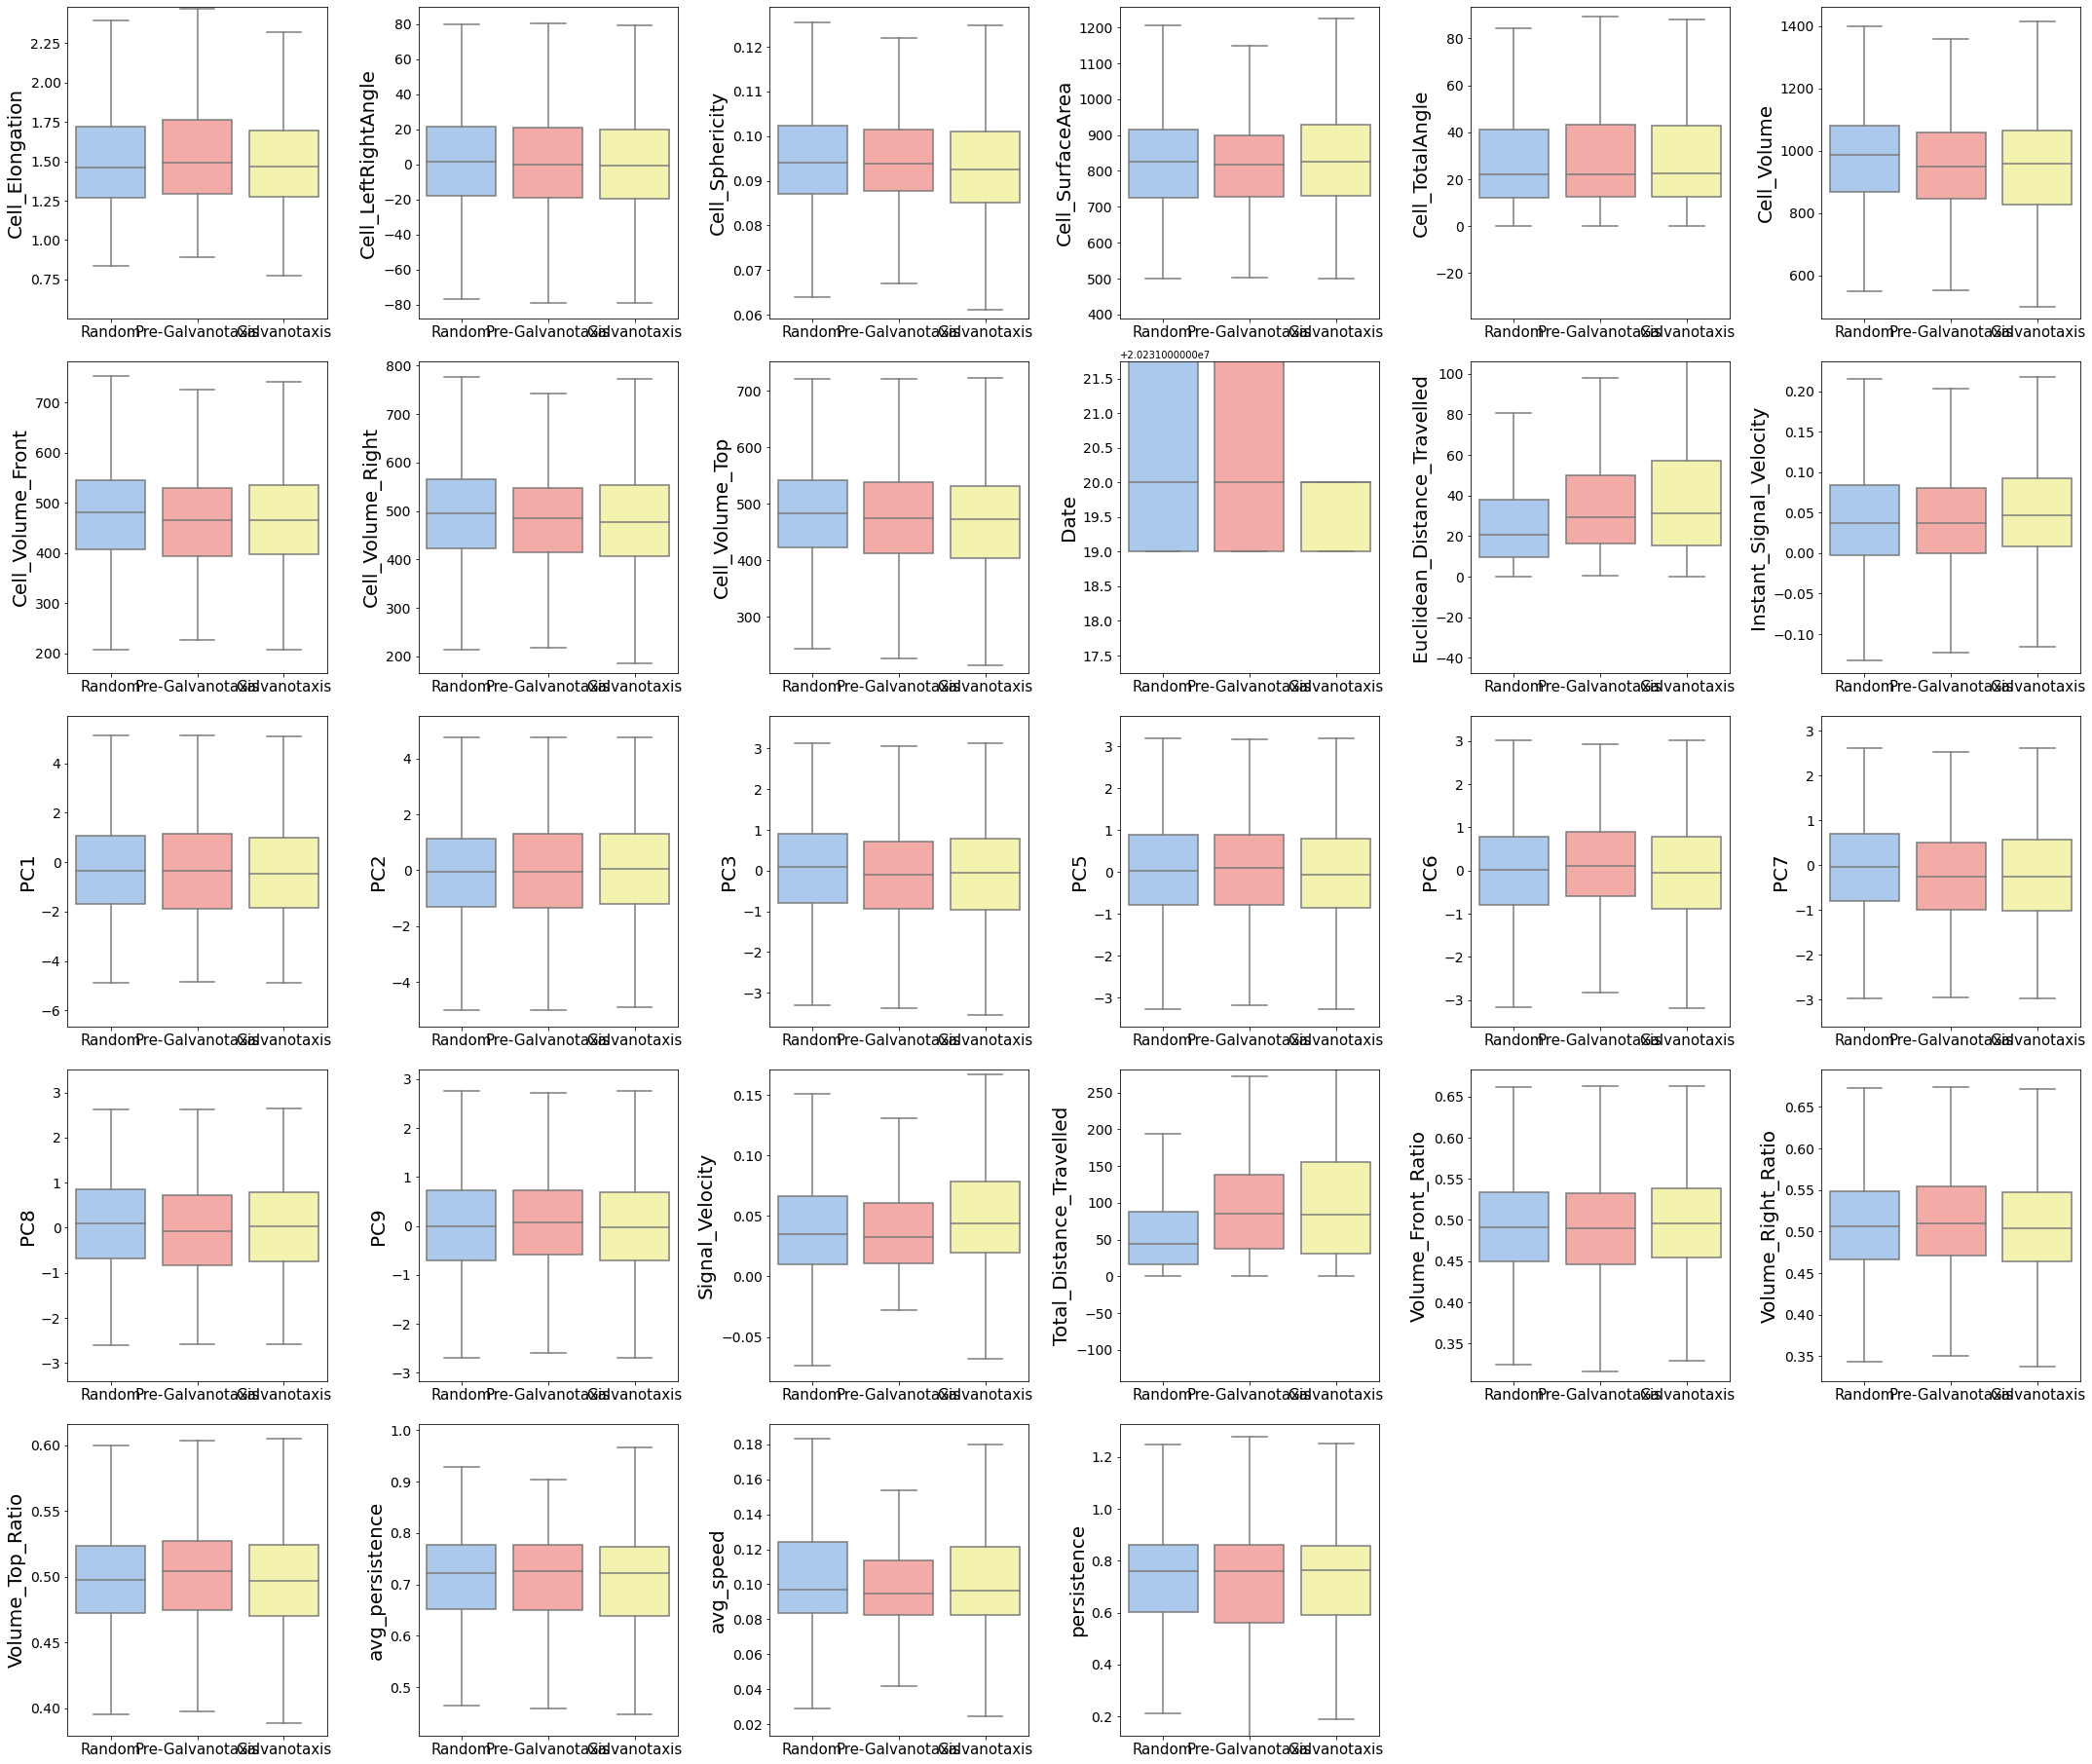

In [7]:
############### Metric distributions by drug #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']

sp = math.ceil(math.sqrt(len(siglist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(siglist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




In [8]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK ####################

############### get list of metrics that are significant using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
confoundlist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c not in ['Treatment','Date','Experiment','Experiment_Number']:
        # Performing two-way ANOVA 
        model = ols(f'{c} ~ C(Date) + C(Experiment_Number) + C(Date):C(Experiment_Number)', 
                    data=ModeFrame).fit() 
        result = sm.stats.anova_lm(model, type=2) 


        if any(result['PR(>F)'].values <0.05):
            # Print the result 
            print(c, result) 
            confoundlist.append(c) 
# siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Cell_Volume                                    df        sum_sq       mean_sq  \
C(Date)                           2.0  3.067896e+06  1.533948e+06   
C(Experiment_Number)              1.0  3.548357e+07  3.548357e+07   
C(Date):C(Experiment_Number)      2.0  7.185238e+06  3.592619e+06   
Residual                      18654.0  4.955936e+08  2.656768e+04   

                                        F         PR(>F)  
C(Date)                         57.737359   1.005255e-25  
C(Experiment_Number)          1335.591217  1.761487e-282  
C(Date):C(Experiment_Number)   135.225136   4.944496e-59  
Residual                              NaN            NaN  
Cell_Volume_Front                                    df        sum_sq       mean_sq  \
C(Date)                           2.0  8.512457e+05  4.256228e+05   
C(Experiment_Number)              1.0  9.799654e+06  9.799654e+06   
C(Date):C(Experiment_Number)      2.0  2.144540e+06  1.072270e+06   
Residual                      18654.0  1.825973e+08  

Euclidean_Distance_Travelled                                    df        sum_sq       mean_sq           F  \
C(Date)                           2.0  4.540643e+04  22703.213551   33.346235   
C(Experiment_Number)              1.0  5.775176e+04  57751.759754   84.825160   
C(Date):C(Experiment_Number)      2.0  1.694826e+05  84741.302939  124.467109   
Residual                      18368.0  1.250554e+07    680.832900         NaN   

                                    PR(>F)  
C(Date)                       3.500600e-15  
C(Experiment_Number)          3.602030e-20  
C(Date):C(Experiment_Number)  2.030676e-54  
Residual                               NaN  
Turn_Angle                                    df        sum_sq      mean_sq          F  \
C(Date)                           2.0  8.303967e+03  4151.983635  40.068225   
C(Experiment_Number)              1.0  3.529596e+02   352.959612   3.406195   
C(Date):C(Experiment_Number)      2.0  2.617931e+02   130.896572   1.263202   
Residual     

Volume_Right_Ratio                                    df     sum_sq   mean_sq         F    PR(>F)
C(Date)                           2.0   0.060929  0.030464  7.772657  0.000422
C(Experiment_Number)              1.0   0.008257  0.008257  2.106695  0.146673
C(Date):C(Experiment_Number)      2.0   0.016627  0.008314  2.121138  0.119924
Residual                      18654.0  73.113075  0.003919       NaN       NaN
Volume_Top_Ratio                                    df     sum_sq   mean_sq         F    PR(>F)
C(Date)                           2.0   0.003463  0.001732  0.991578  0.371011
C(Experiment_Number)              1.0   0.009186  0.009186  5.260635  0.021824
C(Date):C(Experiment_Number)      2.0   0.001336  0.000668  0.382584  0.682102
Residual                      18654.0  32.574481  0.001746       NaN       NaN
Cell_Sphericity                                    df    sum_sq   mean_sq           F  \
C(Date)                           2.0  0.083360  0.041680  299.262234   
C(Experiment

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


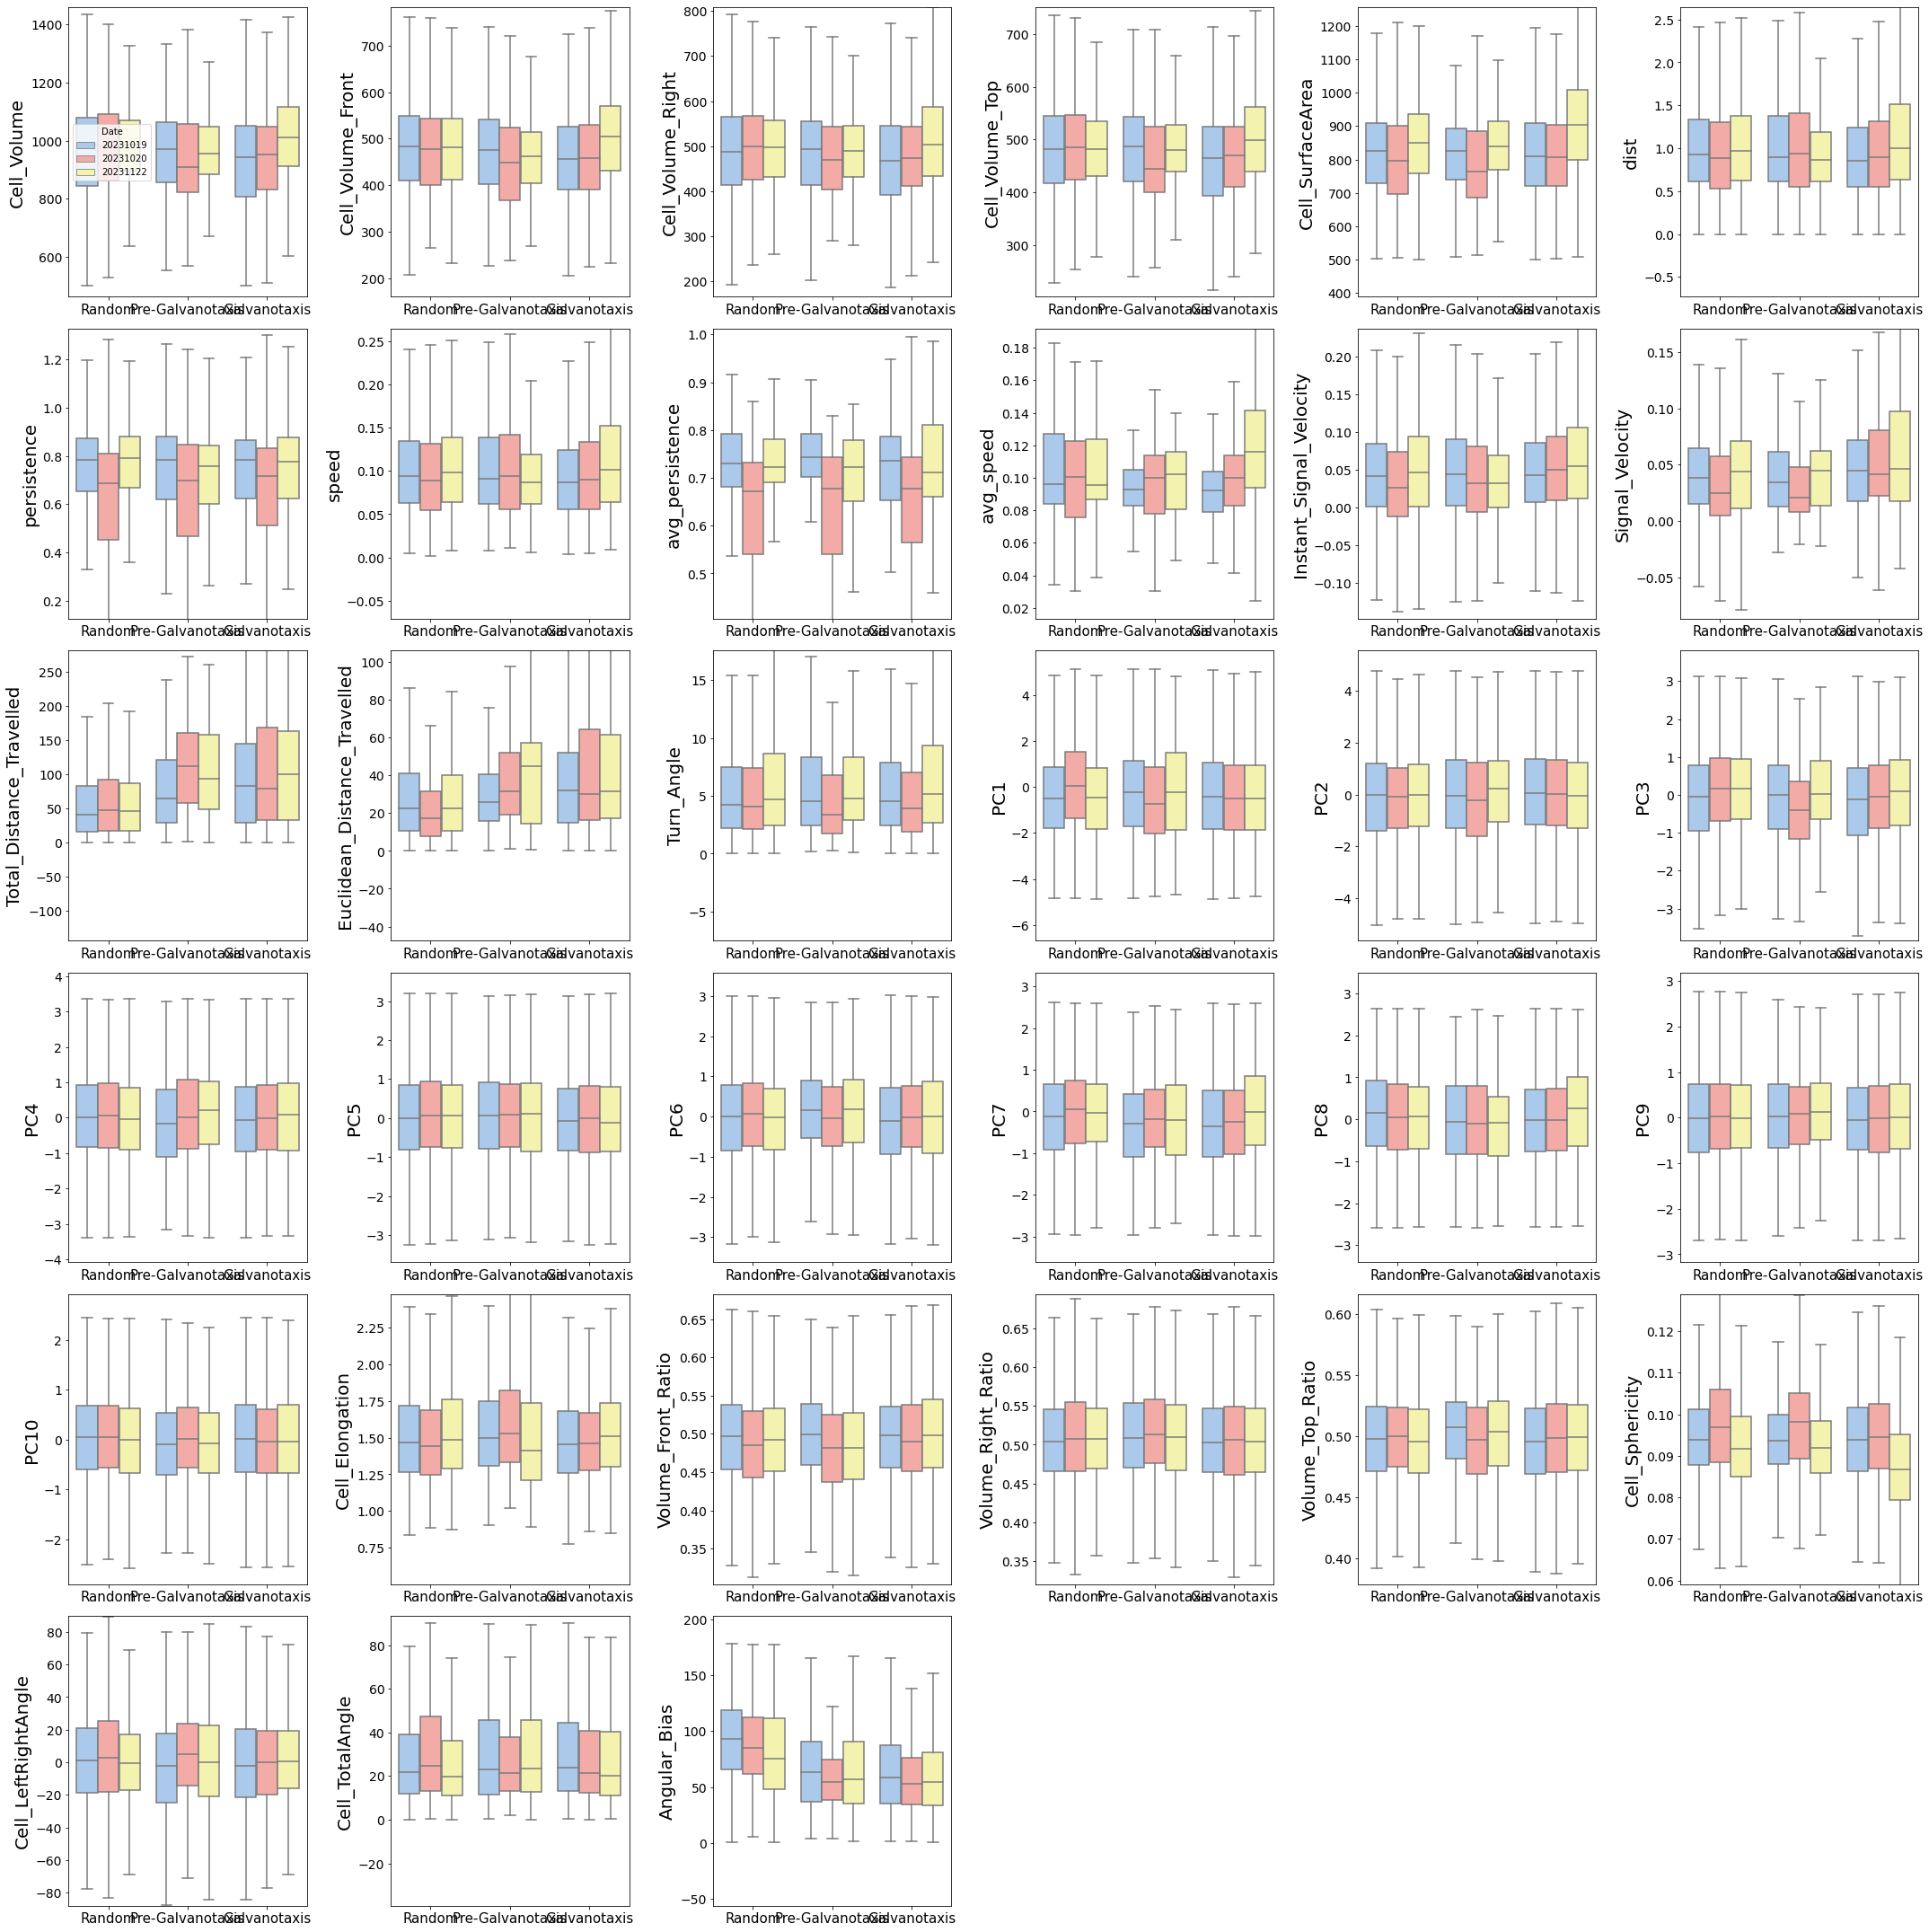

In [9]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY DATE ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']

sp = math.ceil(math.sqrt(len(confoundlist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(confoundlist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, hue = 'Date',palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


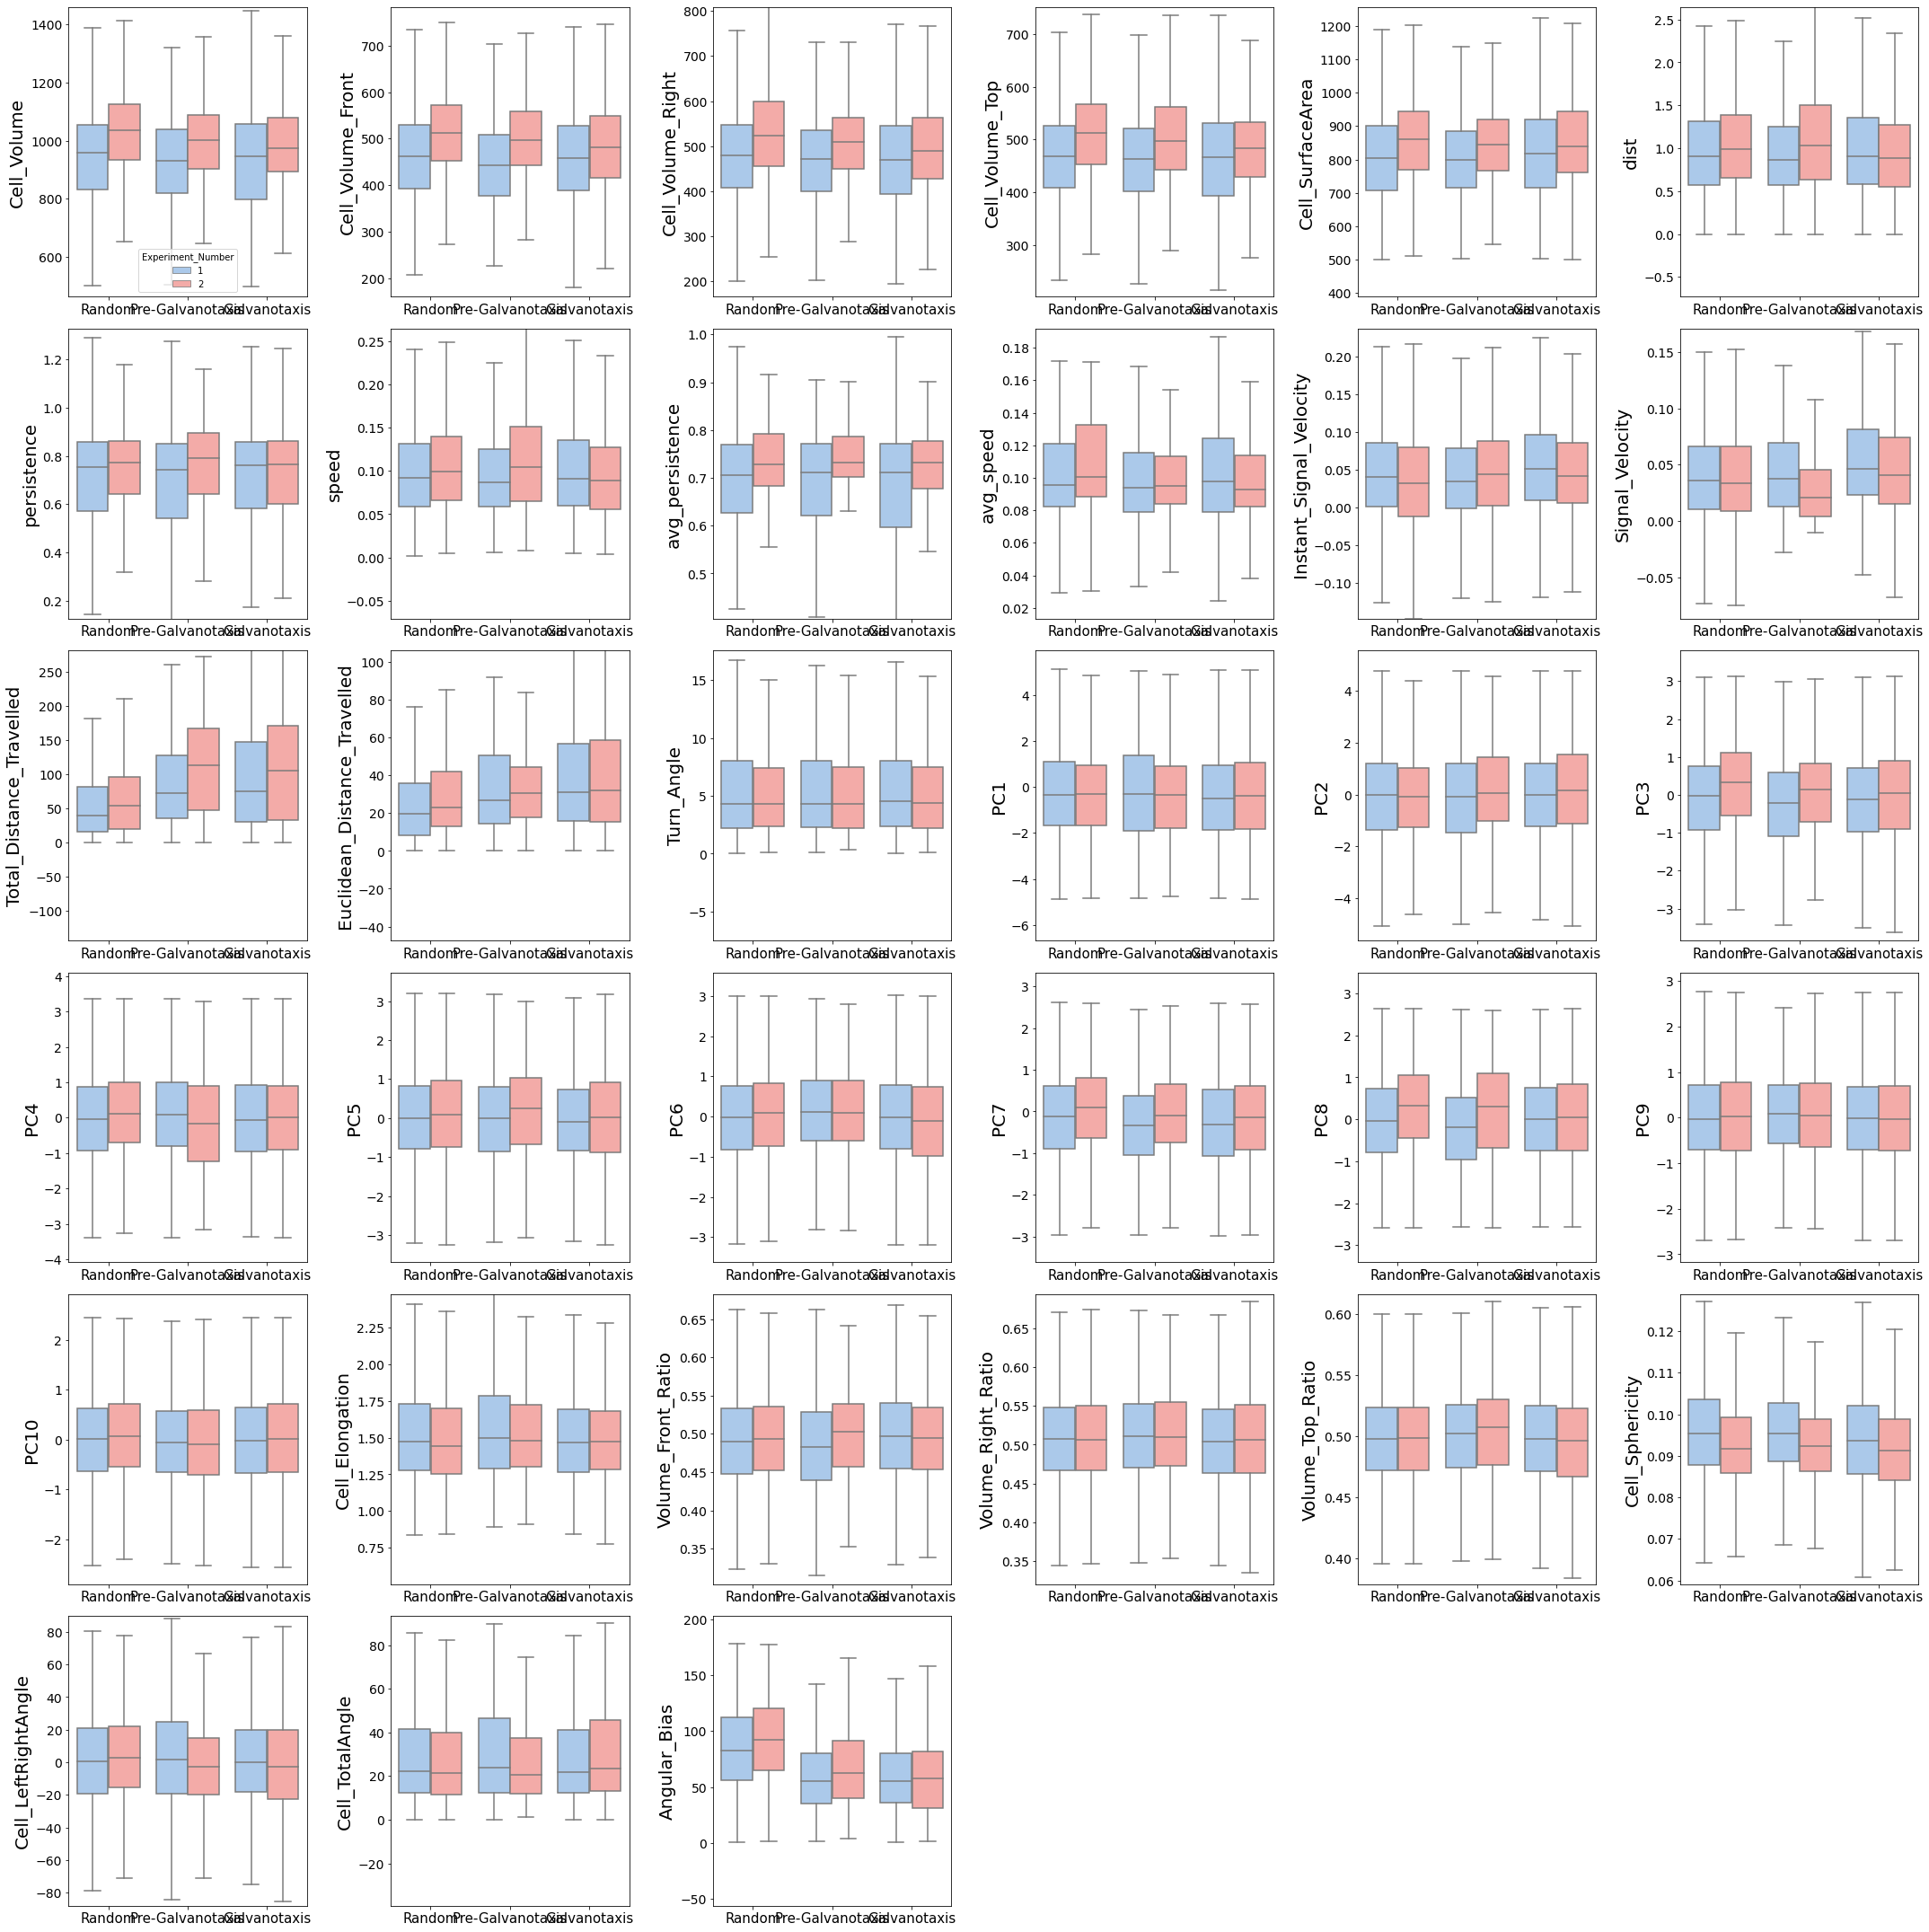

In [10]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY EXPERIMENT NUMBER ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']

sp = math.ceil(math.sqrt(len(confoundlist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(confoundlist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, hue = 'Experiment_Number' ,palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




In [26]:
TotalFrame[TotalFrame.Date ==20231122].Experiment_Number.unique()
# TotalFrame.Date.unique()

array([1], dtype=int64)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


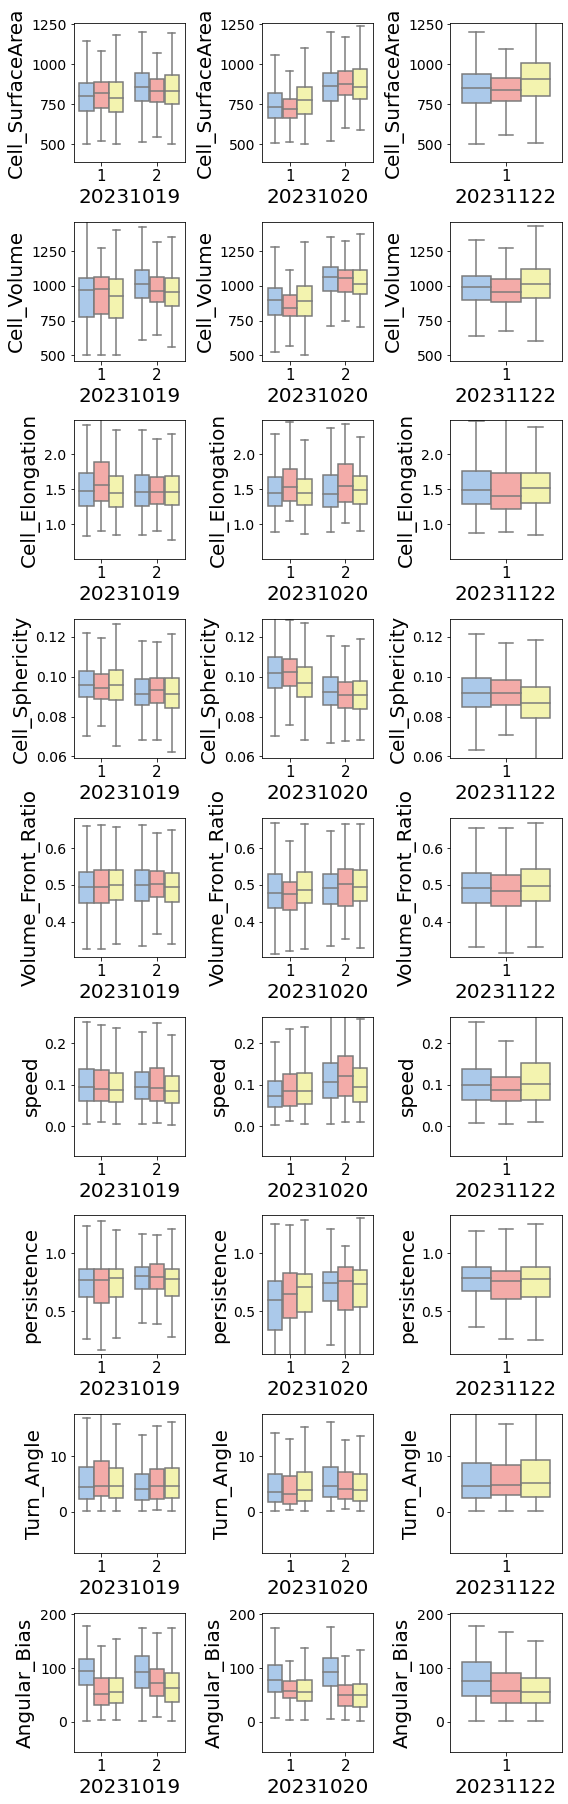

In [28]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY DATE AND EXPERIMENT NUMBER ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']


fig, axes = plt.subplots(len(smallersig), len(TotalFrame.Date.unique()), figsize=(8,25))#, sharex=True)

# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    for d, dd in enumerate(TotalFrame.Date.unique()):
        ax = axes[i,d]
        bp = sns.boxplot(data=TotalFrame[TotalFrame.Date ==dd], x='Experiment_Number', y=sig, hue = 'Treatment' ,palette = colorlist,# width = 0.15, 
                fliersize=0, boxprops={'zorder': 2}, ax=ax)
        Q1 = TotalFrame[sig].quantile(0.25)
        Q3 = TotalFrame[sig].quantile(0.75)  
        IQR = Q3 - Q1
        ax.set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
        ax.set_ylabel(sig, fontsize=20)
        ax.set_xlabel(dd, fontsize=20)
        ax.tick_params('y', labelsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
#         if i>0:
        ax.legend_ = None


    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


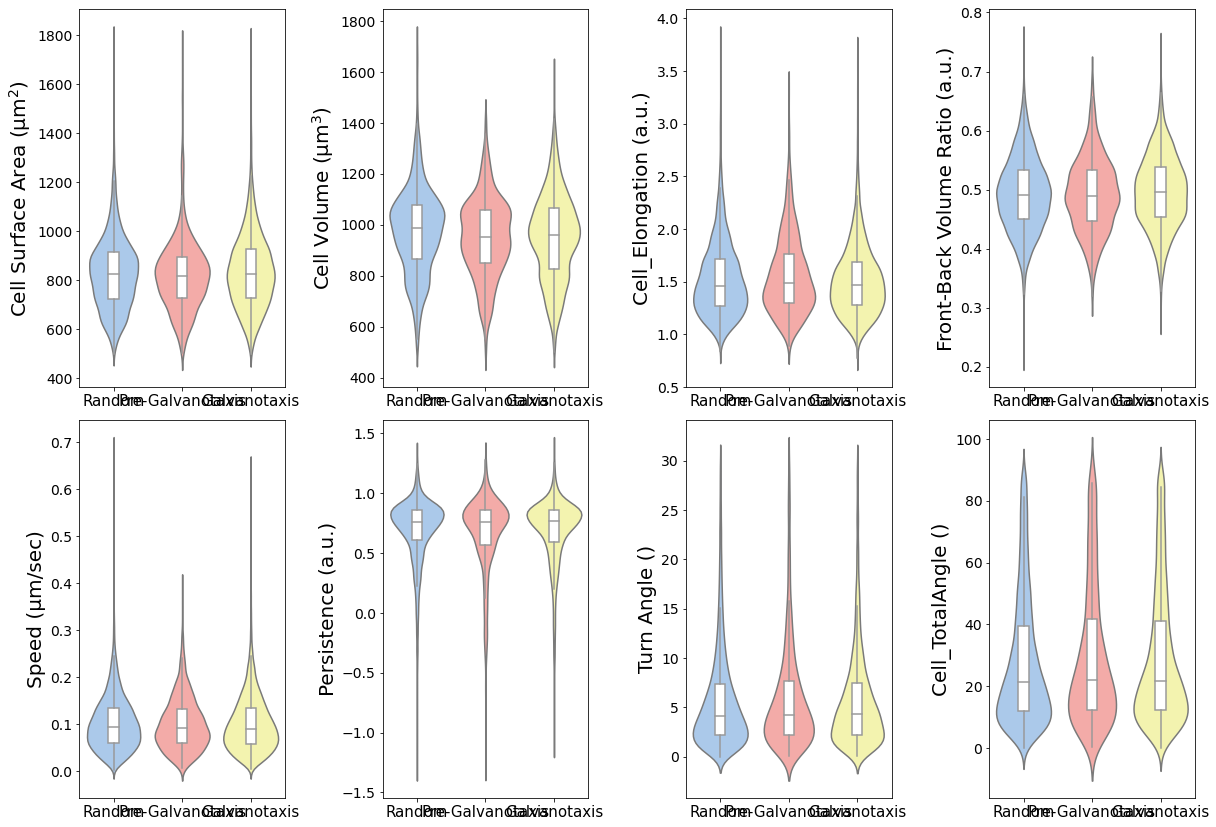

In [19]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle', 'Cell_TotalAngle']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle ()', 'Cell_TotalAngle ()']


fig, axes = plt.subplots(3, 4, figsize=(17,17))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)

for a in range(i+1, len(axli)):
    axli[a].remove()


plt.tight_layout()
plt.savefig(savedir + 'Treatment significant metric violins.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




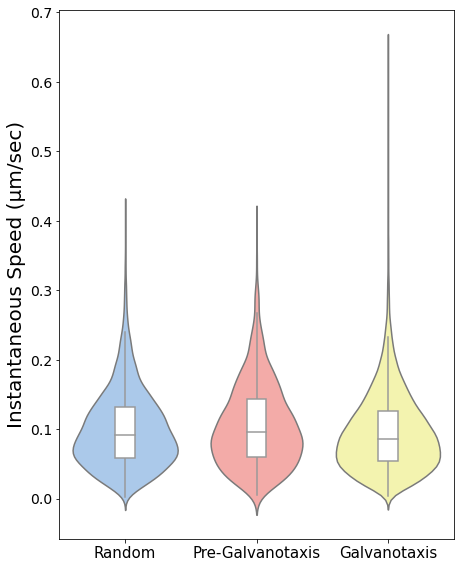

In [34]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = tempframe[tempframe.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['speed']
siglabels = ['Instantaneous Speed (µm/sec)']


fig, ax = plt.subplots(1, 1, figsize=(6.5,8))#, sharex=True)

vp = sns.violinplot(data=tempframe, x='Treatment', y='speed', palette = colorlist, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='speed', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylabel(siglabels[0], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(tempframe.Treatment.unique(), fontsize = 15)#, rotation=45)#, ha = 'right')


plt.tight_layout()
plt.savefig(savedir + 'speed metric violins.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


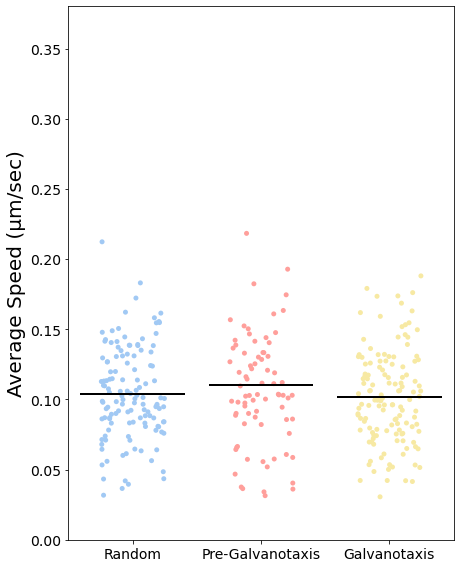

In [79]:
tempframe = TotalFrame[TotalFrame.speed<0.8]
realavg = []
for i, c in tempframe.groupby(['CellID', 'Treatment']):
    realavg.append([i[0], i[1], c.speed.mean()])
newrealavg = pd.DataFrame(realavg, columns = ['CellID','Treatment','Average Speed (µm/sec)'])


colorlist = ['#a1c9f4', '#ff9f9b', '#f7e9a3']

fig, ax = plt.subplots(figsize = (6.5,8))
sns.stripplot(newrealavg['Treatment'],newrealavg['Average Speed (µm/sec)'], jitter = 0.25, palette = colorlist, ax = ax)

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=newrealavg['Treatment'],
            y=newrealavg['Average Speed (µm/sec)'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(),fontsize=20)
ax.set_ylim(0,0.38)
ax.tick_params('x', labelsize=14)
ax.tick_params('y', labelsize=14)


plt.tight_layout()
plt.savefig(savedir + 'average speed metric jitter.png', bbox_inches='tight')

['#a1c9f4', '#ff9f9b', '#fffea3']

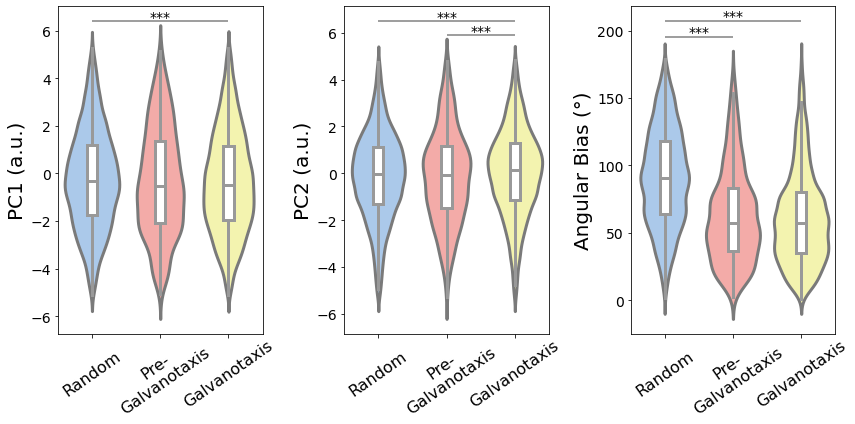

In [46]:
############### Metric distributions by treatment FOR ASCB #################################

import re


#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = tempframe[tempframe.Turn_Angle<30]
# tempframe = tempframe[tempframe.PC1_PC2_distance_to<3]


colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['PC1','PC2','Angular Bias']
siglabels = ['PC1 (a.u.)','PC2 (a.u.)','Angular Bias (°)']



fig, axes = plt.subplots(1, len(smallersig), figsize=(12,6))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, linewidth=3, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(['Random','Pre-\nGalvanotaxis','Galvanotaxis'], fontdict= {'fontsize': 16,
                                                                                      'verticalalignment':'center',
                                                                                      'rotation':35,
                                                                                      'y':-.1})

# ax.tick_params('x', labelsize=16, rotation = 35)

axli[0].hlines(6.4, 0, 2, colors='grey', linestyles='solid')
axli[0].text(1,6.41,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

    
axli[1].hlines(5.9, 1, 2, colors='grey', linestyles='solid')
axli[1].text(1.5,5.91,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[1].hlines(6.5, 0, 2, colors='grey', linestyles='solid')
axli[1].text(1,6.51,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
    

axli[2].hlines(195, 0, 1, colors='grey', linestyles='solid')
axli[2].text(0.5,196,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(207, 0, 2, colors='grey', linestyles='solid')
axli[2].text(1,208,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

    
    
plt.tight_layout()
plt.savefig(savedir + f'treatment metric violins FOR ASCB 2023.png', bbox_inches='tight')



In [23]:
for i, x in TotalFrame.groupby('Treatment'):
    print(i,x.PC1_PC2_distance_to.mean())

Random 1.4889567493594047
Pre-Galvanotaxis 1.3944488708735976
Galvanotaxis 1.376317035792713


In [84]:
TotalFrame.columns

Index(['cell', 'Euler_angles_X', 'Euler_angles_Y', 'Euler_angles_Z',
       'Width_Rotation_Angle', 'Cell_Centroid_X', 'Cell_Centroid_Y',
       'Cell_Centroid_Z', 'Cell_Volume', 'Cell_Volume_Front',
       'Cell_Volume_Right', 'Cell_Volume_Top', 'Cell_SurfaceArea',
       'Cell_MajorAxis', 'Cell_MajorAxis_Vec_X', 'Cell_MajorAxis_Vec_Y',
       'Cell_MajorAxis_Vec_Z', 'Cell_MinorAxis', 'Cell_MinorAxis_Vec_X',
       'Cell_MinorAxis_Vec_Y', 'Cell_MinorAxis_Vec_Z', 'Cell_MiniAxis',
       'Cell_MiniAxis_Vec_X', 'Cell_MiniAxis_Vec_Y', 'Cell_MiniAxis_Vec_Z',
       'OriginaltoReconError', 'RecontoOriginalError', 'structure', 'frame',
       'x', 'y', 'z', 'Cell_intensity_mean', 'Cell_intensity_std',
       'Cell_intensity_1pct', 'Cell_intensity_99pct', 'Cell_intensity_max',
       'Cell_intensity_min', 'dist', 'persistence', 'activity', 'speed',
       'avg_persistence', 'avg_activity', 'avg_speed',
       'Instant_Signal_Velocity', 'Signal_Velocity',
       'Total_Distance_Travelled', 'Eu

KeyboardInterrupt: 

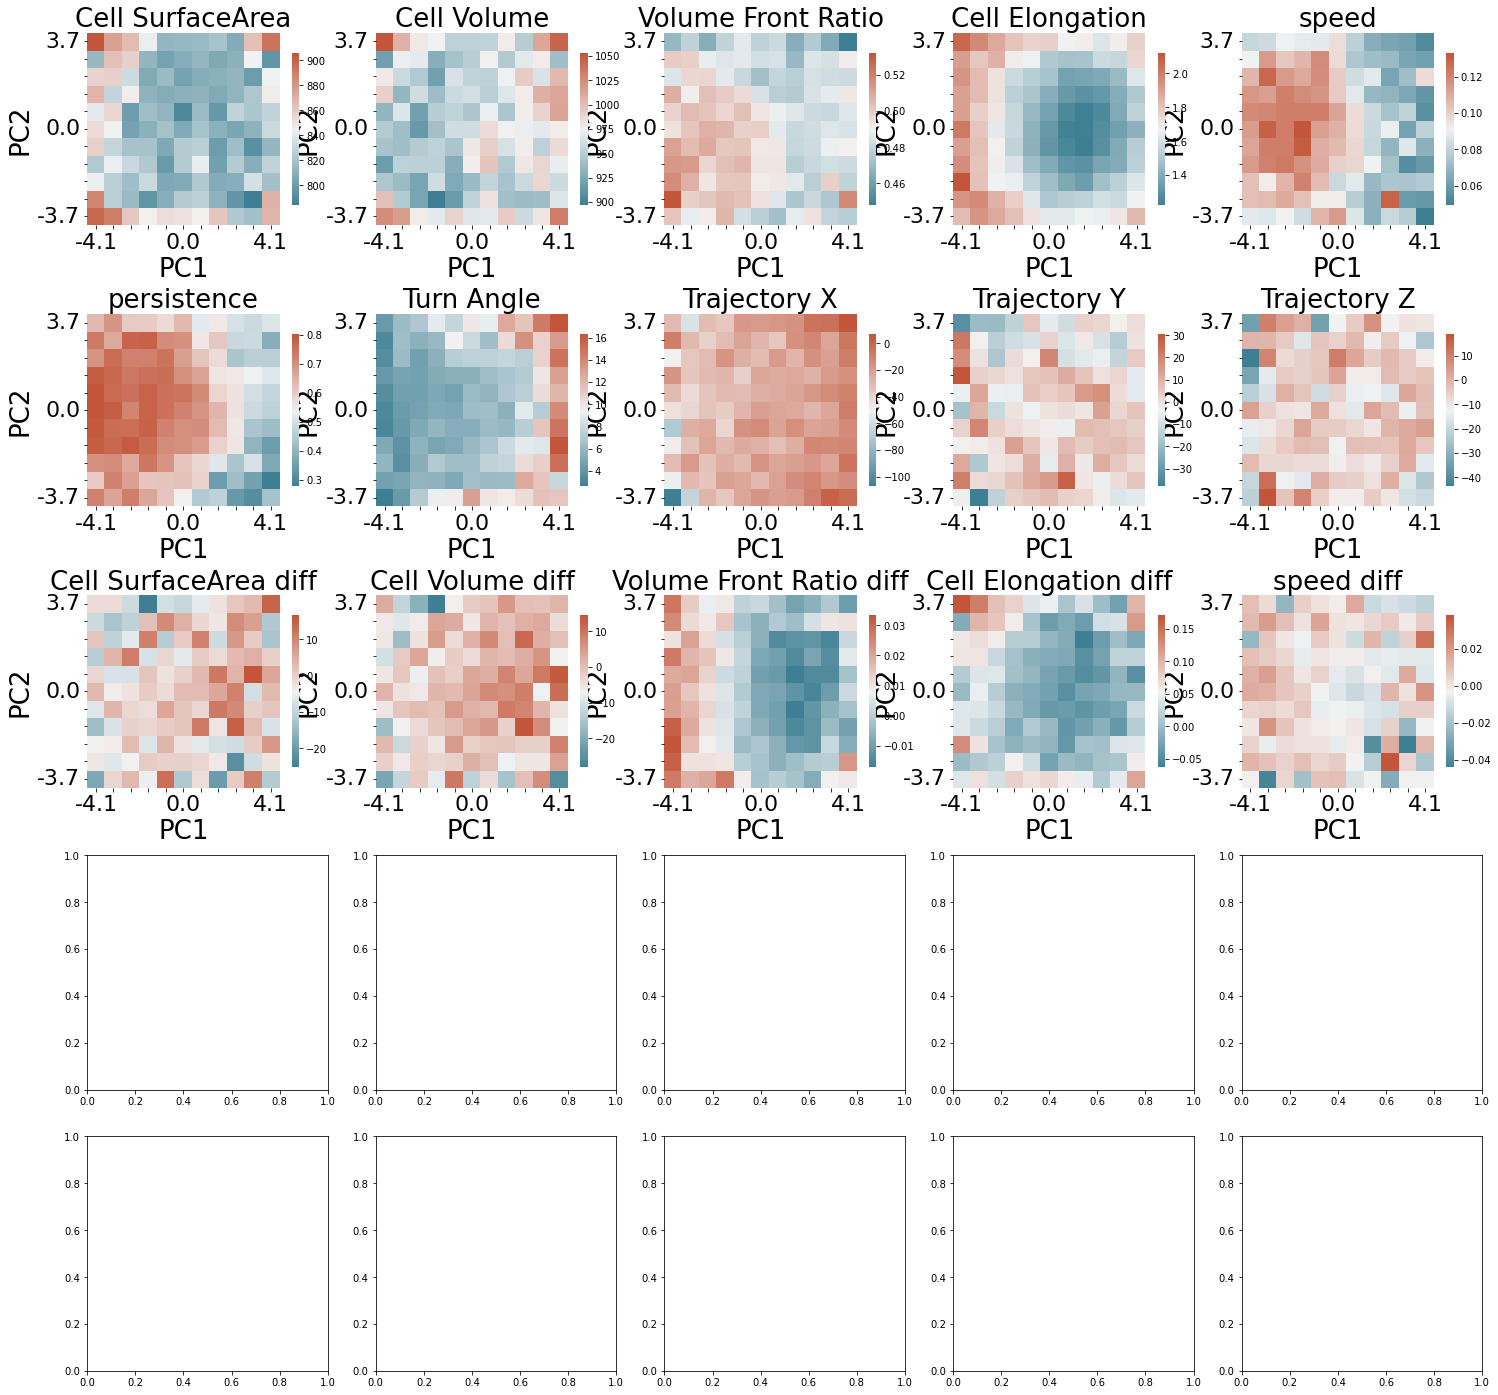

In [85]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed',
           'persistence','Turn_Angle','Trajectory_X','Trajectory_Y', 'Trajectory_Z']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i].replace('_',' '), fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
# plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

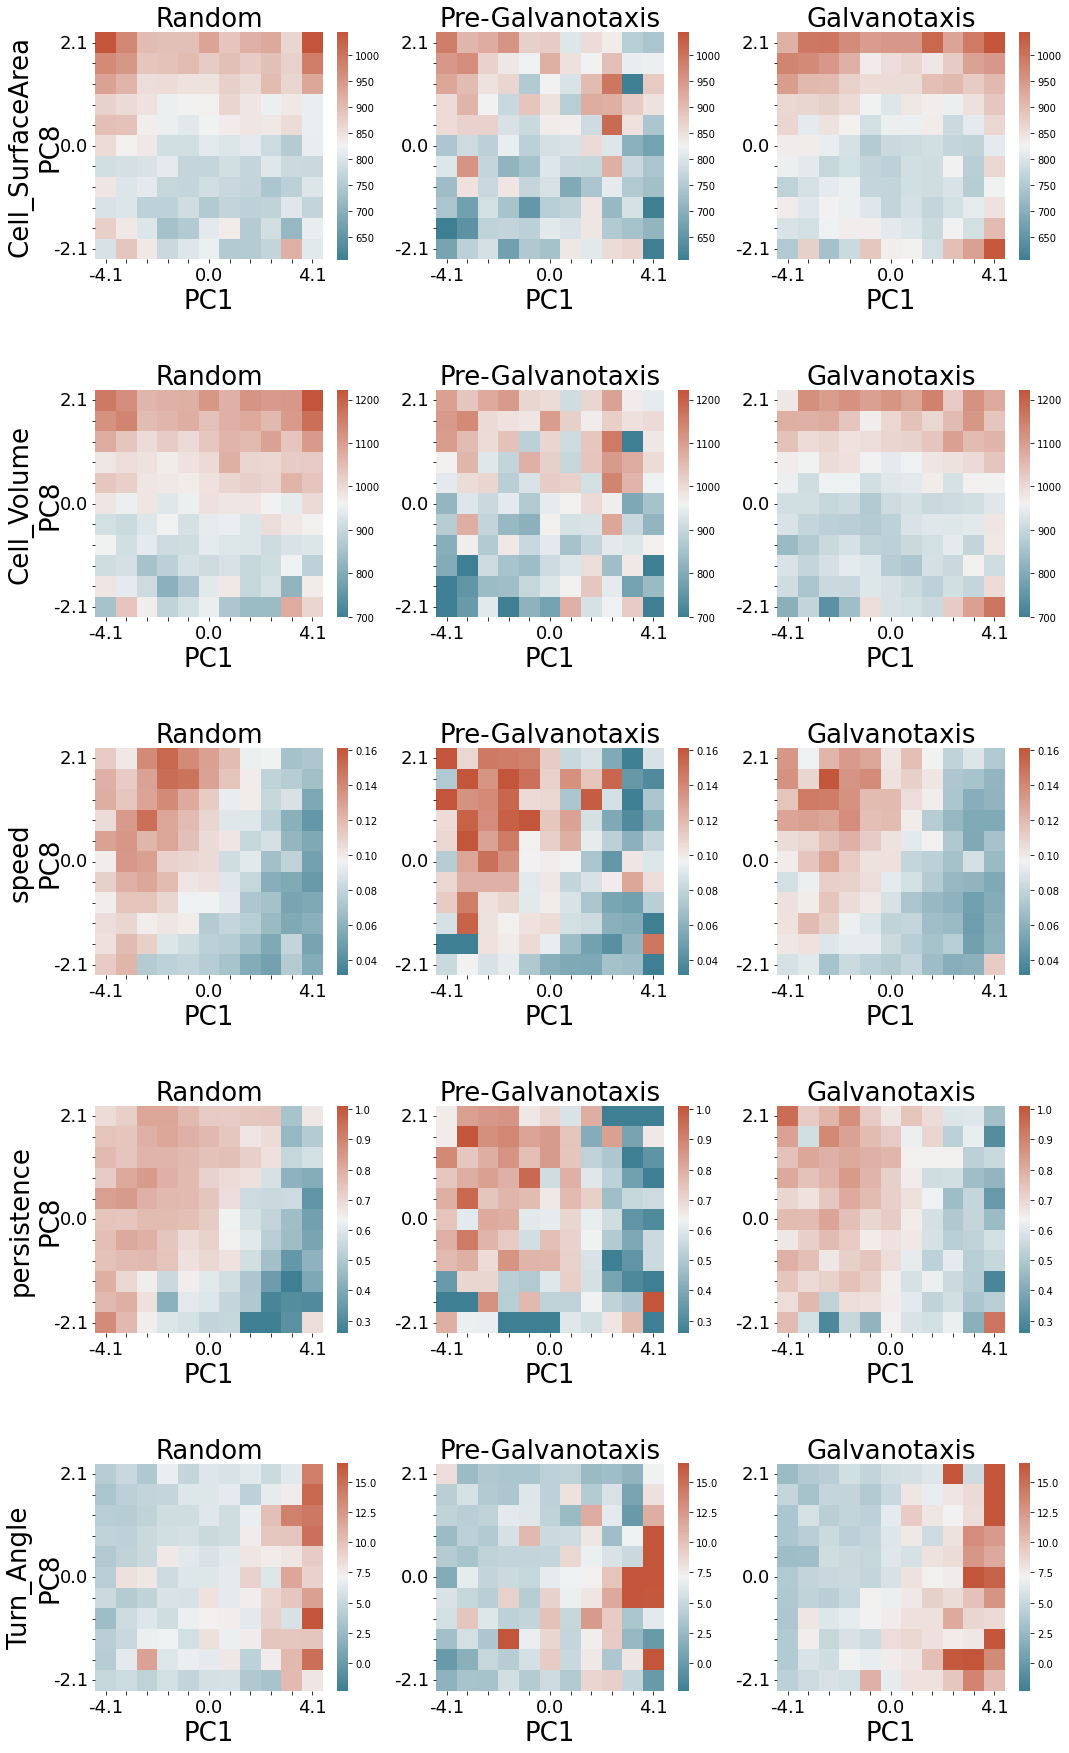

In [84]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Treatment.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Treatment.unique()[a]
        mdf = TotalFrame[TotalFrame.Treatment==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC8bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.mean(bighm[np.nonzero(bighm)])-(bighm.std()*2),
            vmax=np.mean(bighm)+(bighm.std()*2), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 18
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC8.to_list()],
            rotation=0,
            fontsize = 18
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC8', fontsize = 26, labelpad=-10)

        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC8 metric heatmaps separated.png', bbox_inches='tight')

In [85]:
############## get 1D cycle for PC dynamics ##############
### get centered PC bins first
x = TotalFrame.PC1bins.values-6
y = TotalFrame.PC8bins.values-6
### calculate angular coord and radius
TotalFrame['PC1_PC8_Angular_Coord'] = [angle360(x1, y1) for x1, y1 in zip(x, y)]
TotalFrame['PC1_PC8_Radial_Coord'] = np.sqrt(x**2 +y**2)
### "bin" the Angular coord
TotalFrame['PC1_PC8_Angular_Bins'] = [math.ceil(i) for i in TotalFrame['PC1_PC8_Angular_Coord']]

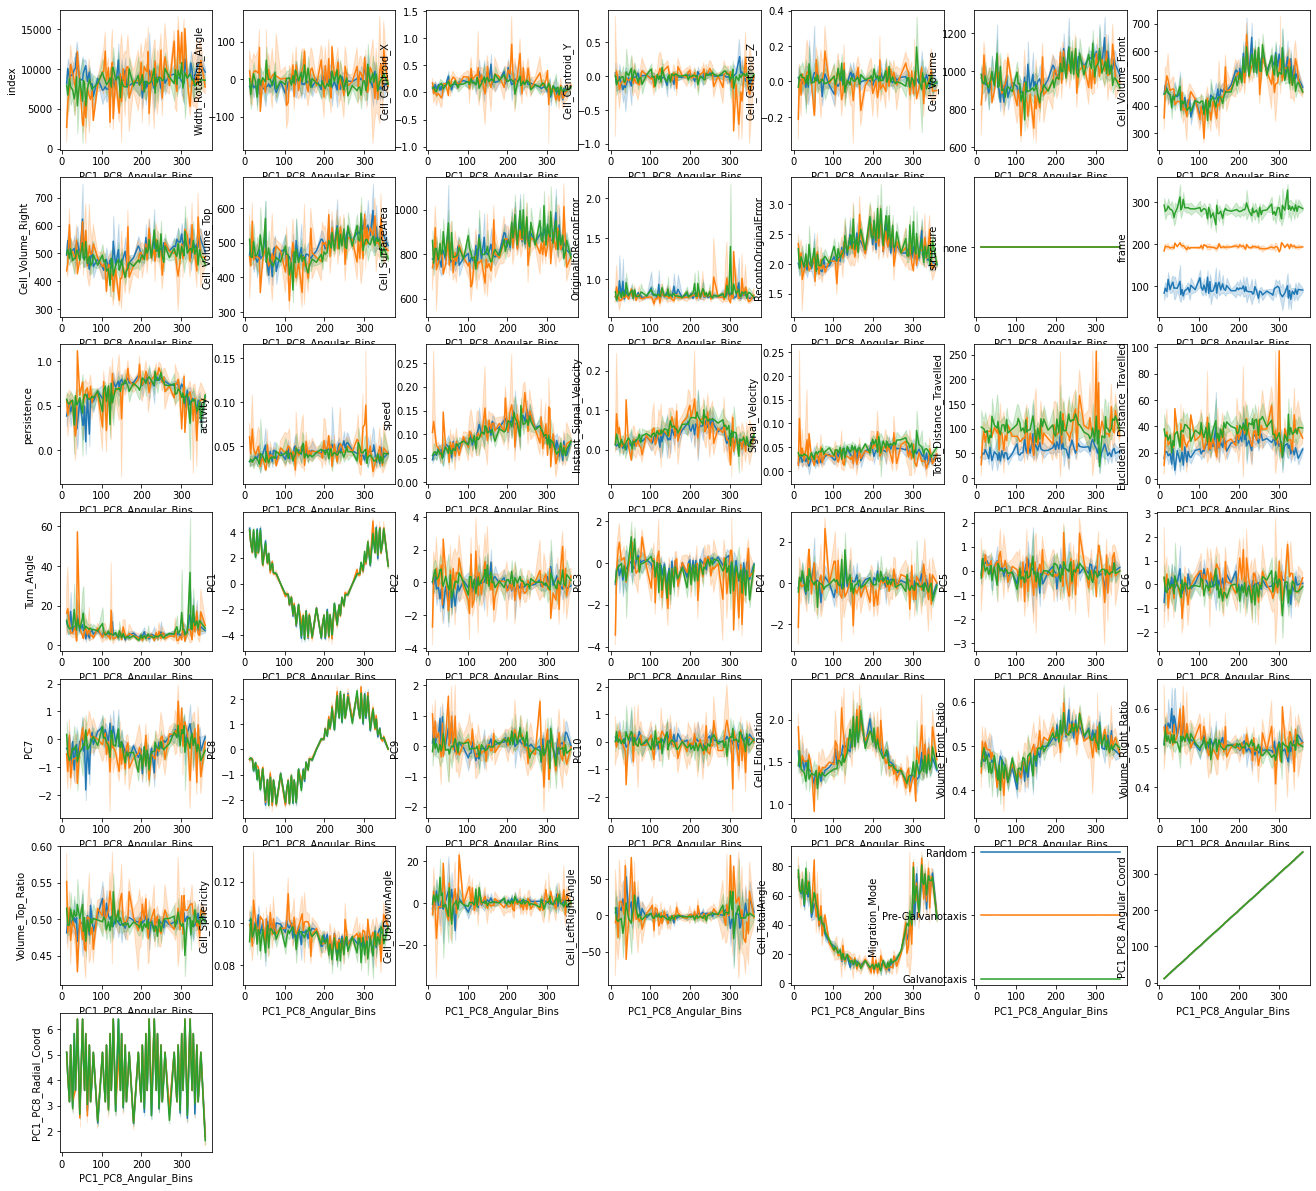

In [86]:
newframe = TotalFrame.drop(columns =to_remove)
removeex = []
removeex.extend([x for x in newframe.columns if 'Euler' in x])
removeex.extend([x for x in newframe.columns if 'avg' in x])
removeex.extend([x for x in newframe.columns if 'PC1_PC2' in x])
removeex.extend([x for x in newframe.columns if 'intensity' in x])
removeex.extend(['cell','CellID','x','y','z', 'dist'])
newframe = newframe.drop(columns =removeex)


################# LOOK AT STAT DISTRIBUTIONS ######################

CoRo = math.ceil(math.sqrt(len(newframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(newframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.lineplot(x='PC1_PC8_Angular_Bins', y = newframe.iloc[:,i].name, hue = 'Treatment', data = TotalFrame, ax = ax)
    ax.set_ylabel(newframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    ax.legend_ = None
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

# plt.tight_layout()
plt.savefig(savedir + 'Shape Metrics 1D.png', bbox_inches='tight')